In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import math
import random
from tqdm import tqdm
import pyinform as pi
import networkx as nx
from mpl_toolkits.basemap import Basemap
import scipy.spatial as ss
#import scipy.stats as sst
from scipy.special import digamma,gamma
from math import log
import itertools
import operator
import ast
import collections
#from sklearn.feature_selection import mutual_info_classif # For calculating mutual information

# For importing functions
import ipynb
import sys  

# Import data
sys.path.insert(0, 'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Extraction_Partitioning_Functions')

from ipynb.fs.full.Data_Extraction_Functions import three_month_extraction,five_month_extraction,extract_region_lists,mcrobie_djfjja_0,mcrobie_five_0

from ipynb.fs.full.Partitioning_Functions import regional_ordinal_sequence,block_ordinal_sequence

# Import Datasets

In [2]:
# Import datasets with zeroes 
five_month_0 = mcrobie_five_0()
five_monthly_0 = five_month_0[1:]

# With zeros extracted
five_month = extract_region_lists(three_month=False)
ndjfm_dates = five_month[0]
mjjas_dates = five_month[1]
five_monthly = five_month[2:]

Order: date, nw, nee, mc, io, eep, ism, easm
NDJFM/MJJAS Order: NDJFM_dates,MJJAS_dates,nw,ne,mc,ioo,eep,ism,easm


In [3]:
names = ['NW_Aus', 'NE_Aus', 'MC', 'IO', 'EEP', 'ISM', 'EASM']
regions = [x for x in range(7)]

permutation_names = []
for i,j in itertools.combinations(regions,2):
    name = [names[i],names[j]]
    permutation_names.append(name)

# Mutual Information Functions

In [4]:
def my_mutual_information(x,y,bins): # Function to calculate mutual information between two time series x, y    
    p_x = np.histogram(x, bins=bins)[0]/len(x) # Find probability distribution of x
    p_xy = np.histogram2d(x,y,bins=bins)[0]/(len(x)+len(y)) # Find joint probability distribution
    
    sum_x = 0 # Calculate first part of mutual information formula
    for i in range(len(p_x)):
        if p_x[i] != 0:
            sum_x += p_x[i]*np.log10(p_x[i])
        else:
            pass
    
    sum_xy = 0 # Calculate second part of mutual information formula
    for i in range(len(p_xy)):
        for j in range(len(p_xy)):
            if p_xy[i][j] != 0:
                sum_xy += p_xy[i][j]*np.log10(p_xy[i][j])
            else:
                pass
    
    MI = sum_xy - 2*sum_x # Calculate mutual information
    
    return MI

def actual_mi(region_input,bins):
    actual_mi = []
    region_index = [i for i in range(len(region_input))]
    for i,j in itertools.combinations(region_index,2):
        mi = my_mutual_information(region_input[i],region_input[j],bins)
        actual_mi.append(mi)
    return actual_mi

# Surrogate Functions

In [6]:
def white_noise_surrogates(original_data):
    '''
    Return a shuffled copy of a time series array.

    Each time series is shuffled individually. The surrogates correspond to
    realizations of white noise consistent with the :attr:`original_data`
    time series' amplitude distribution.
    '''
    
    shuffle = random.shuffle
    surrogate = original_data.copy()
    for i in range(surrogate.shape[0]):
        shuffle(surrogate[i,:])
    return surrogate

In [7]:
def chopped(region_input,block_length):
    chop = []
    for i in range(len(region_input)):
        time_series = list(region_input[i])
        chunked_list = [time_series[i:i+block_length] for i in range(0, len(time_series), block_length)]
        for j in range(len(chunked_list)):
            act_len = len(chunked_list[j])
            if act_len != block_length:
                chunked_list.remove(chunked_list[j])
            else:
                pass
        chop.append(chunked_list)
    
    full_indices = []
    for i in range(len(chop)):
        component_indices = []
        for j in range(len(chunked_list[i])):
            component_indices.append(j)
        full_indices.append(component_indices)

    return np.asarray(full_indices),np.asarray(chop)

In [8]:
def chopped_surrogate(region_input,block_length): ## USES ONLY THE WHITE NOISE ALGORITHM
    sliced_indices,sliced_values = chopped(region_input,block_length) # Chop up all time series into blocks of length block_length
    
    orders = []
    for i in range(len(sliced_values)):
        block = sliced_values[i]
        
        block_index = []
        for j in range(len(block)):
            block_index.append(j)
        orders.append(block_index)
    
    shuffled = np.asarray(orders)
    surrogates = white_noise_surrogates(shuffled)
    
    shuffled_all = []
    for i in range(len(surrogates)):
        orders = surrogates[i]
        shuffled_component = []
        for j in range(len(orders)):
            value = sliced_values[i][orders[j]]
            shuffled_component.append(value)
        shuffled_all.append(shuffled_component)
    
    for i in range(len(shuffled_all)):
        shuffled_all[i] = np.hstack(shuffled_all[i])
        
    return shuffled_all

# Plotting Functions

In [9]:
def connections_summary_for_plot(connections_raw):
    connections_test = []
    edge_from_test = []
    edge_to_test = []
    for i in range(len(connections_raw)):
        if connections_raw[i][1] == 1:
            begin = connections_raw[i][0][0]
            end = connections_raw[i][0][1]
            value = 1
            
            edge_from_test.append(begin)
            edge_to_test.append(end)
            connections_test.append(value)
        else:
            pass
    return edge_from_test,edge_to_test

def nodes_latlon_dict():
    m = Basemap(projection = 'merc',
            llcrnrlat=-40,
            llcrnrlon=40,
            urcrnrlat=40,
            urcrnrlon=260,
            resolution='l') #requires initialisation of the map
    
    region_names = ['NW_Aus','NE_Aus','MC','IO','EEP','ISM','EASM']
    region_lat = [-15.000000,-15.000000,-2.500000,-7.500000,5.000000,15.000000,15.000000]
    region_lon = [127.500000,145.000000,120.000000,52.500000,240.000000,85.000000,110.000000]
    mx,my = m(region_lon,region_lat)
    
    coords =list(tuple(zip(mx,my)))
    pos = dict(zip(region_names,coords))
    
    return pos

def network_map_plot(connections_summary_input):
    pos = nodes_latlon_dict()
    test_graph = connections_summary_for_plot(connections_summary_input)
    
    m = Basemap(projection = 'merc',
            llcrnrlat=-40,
            llcrnrlon=40,
            urcrnrlat=40,
            urcrnrlon=260,
            resolution='l')
   
    G = nx.Graph()
    
    for i in range(len(test_graph[0])):
        begin = test_graph[0][i]
        end = test_graph[1][i]
        G.add_edge(begin,end)
    
    plt.figure(figsize=(12,15))
    
    nx.draw_networkx(G,pos,node_size=100,node_color='red',with_labels=False,width=1.5)
    
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-40.,41.,10.),
                    labels=[True,True,False,False],
                    dashes=[2,2],
                    linewidth=0.0)
    m.drawmeridians(np.arange(40.,260.,20.),
                    labels=[False,False,False,True],
                    dashes=[2,2],
                    linewidth=0.0)
    plt.show();

# Original Mutual Information Implementation

In [10]:
def chopped_surrogate_testing_mi(region_input,n_trials,block_length,mi_bins): # Input original region_input (function applies chopped_surrogate())
    #print('Using "white_noise_surrogates" algorithm.')
    n_tests = 21

    test_mi = np.zeros((n_tests+1,n_trials))
    
    for i in tqdm(range(n_trials)):
        surrogate_input = chopped_surrogate(region_input,block_length)
        counter = 0
        for a,b in itertools.combinations(regions,2):
            mi = my_mutual_information(surrogate_input[a],surrogate_input[b],mi_bins)
            counter += 1 
            test_mi[counter][i] = mi
            
    test_mi_results = np.delete(test_mi,0,0)
    
    return test_mi_results

def return_statistical_significance_mi(actual_results,test_results,sig_level): # Actual = actual time series, theory = simulation surrogates
    region_compare_percentile = []
    for i in range(len(test_results)):
        percentile = np.percentile(test_results[i],sig_level)
        region_compare_percentile.append(percentile)
    
    synchronisation = []
    for i in range(len(test_results)):
        if region_compare_percentile[i] <= actual_results[i]:
            synchronisation.append(1)
        else:
            synchronisation.append(0)
    return list(zip(permutation_names,synchronisation))

In [11]:
n_trials = 1000
shuffle_block_length = 12 #Shuffle by monsoon season of 3 months

In [12]:
actual_mutual_informations_5 = actual_mi(five_monthly_0,20)
surrogate_mi_5 = chopped_surrogate_testing_mi(five_monthly_0,
                                              n_trials,
                                              shuffle_block_length,
                                              20)

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.11it/s]


(['NW_Aus', 'NE_Aus'], 1)
(['NW_Aus', 'MC'], 1)
(['NW_Aus', 'IO'], 0)
(['NW_Aus', 'EEP'], 0)
(['NW_Aus', 'ISM'], 1)
(['NW_Aus', 'EASM'], 1)
(['NE_Aus', 'MC'], 0)
(['NE_Aus', 'IO'], 0)
(['NE_Aus', 'EEP'], 0)
(['NE_Aus', 'ISM'], 1)
(['NE_Aus', 'EASM'], 1)
(['MC', 'IO'], 0)
(['MC', 'EEP'], 0)
(['MC', 'ISM'], 1)
(['MC', 'EASM'], 1)
(['IO', 'EEP'], 0)
(['IO', 'ISM'], 1)
(['IO', 'EASM'], 1)
(['EEP', 'ISM'], 1)
(['EEP', 'EASM'], 1)
(['ISM', 'EASM'], 1)


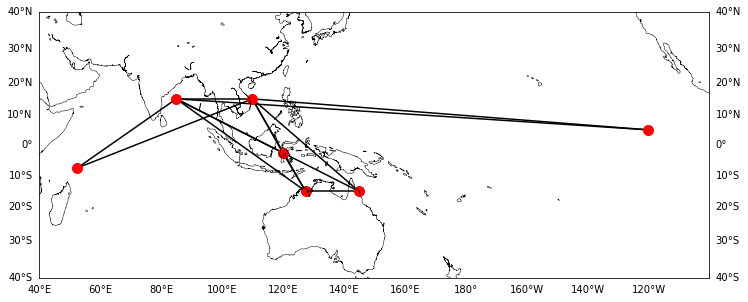

In [13]:
test_results_5 = return_statistical_significance_mi(actual_mutual_informations_5,
                                                 surrogate_mi_5,
                                                 99)
for j in range(len(test_results_5)):
    print(test_results_5[j])
network_map_plot(test_results_5)

# Add Noise to Time Series

In [17]:
def add_noise(regional_block,snr):
    noisy_block = np.zeros((7,len(regional_block[0])))
    for i in range(len(regional_block)):
        time_series = regional_block[i]
        series_mean = np.mean(five_monthly[i]) # Mean without zeros
        
        noisy_time_series = []
        for j in range(len(time_series)):
            random_noise = np.random.normal(0,series_mean*snr)
            
            if time_series[j] != 0:
                perturbed_obs = time_series[j] + random_noise
                noisy_block[i][j] = perturbed_obs
            else:
                noisy_block[i][j] = 0
    
    return noisy_block

Mutual Information Noise level: 0.4
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.29it/s]


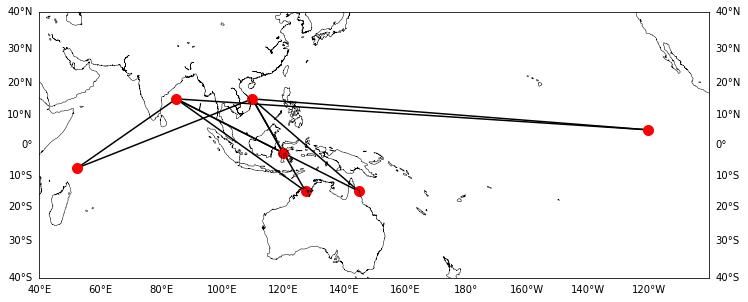

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.78it/s]


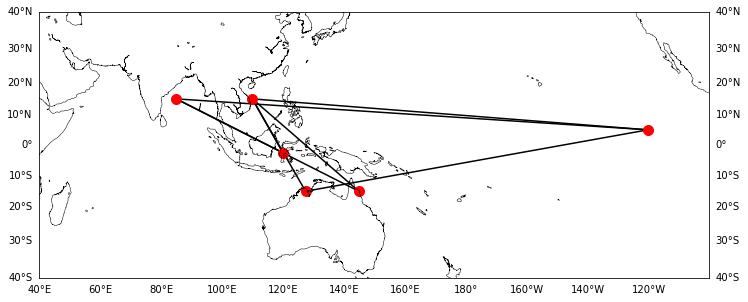

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.94it/s]


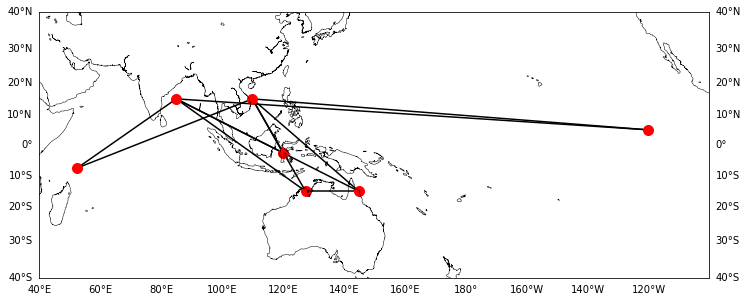

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.23it/s]


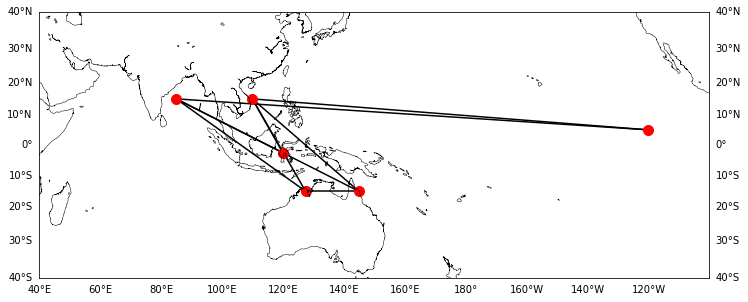

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.11it/s]


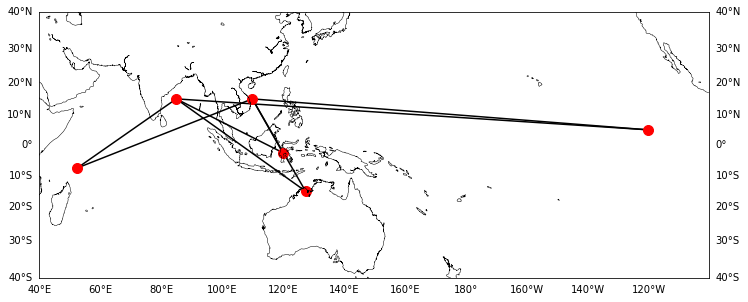

Mutual Information Noise level: 0.5
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.94it/s]


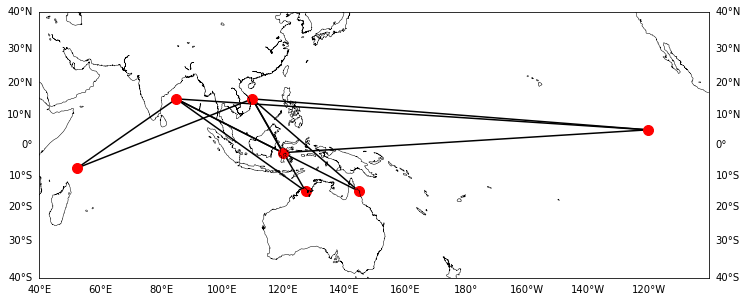

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.70it/s]


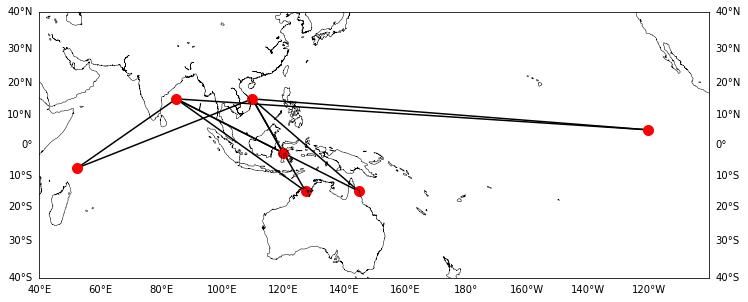

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.92it/s]


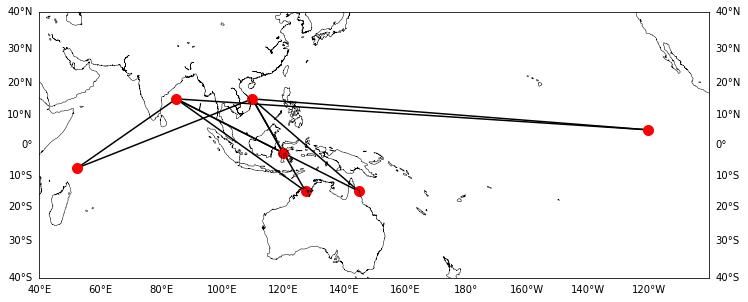

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.17it/s]


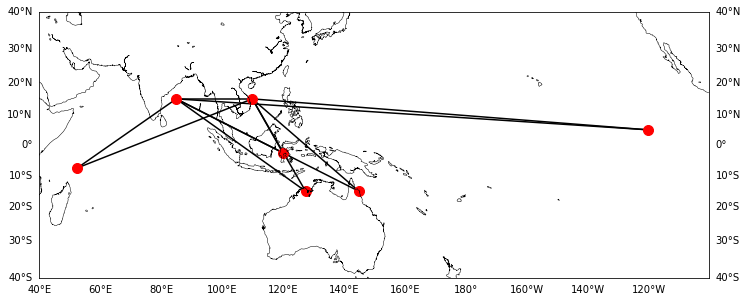

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.25it/s]


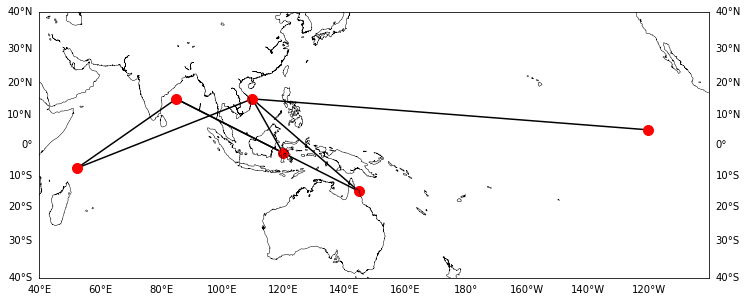

Mutual Information Noise level: 0.6
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.99it/s]


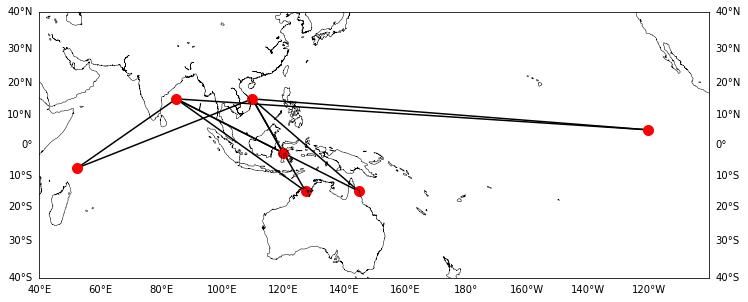

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.14it/s]


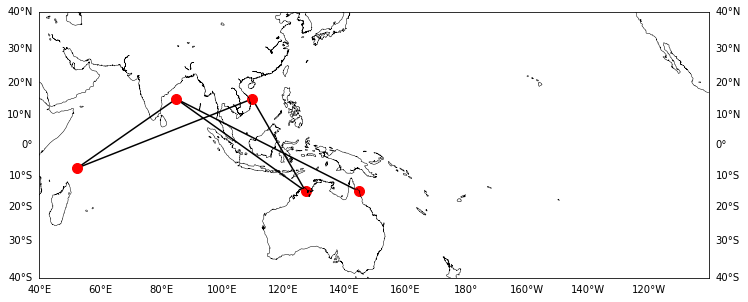

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 32.22it/s]


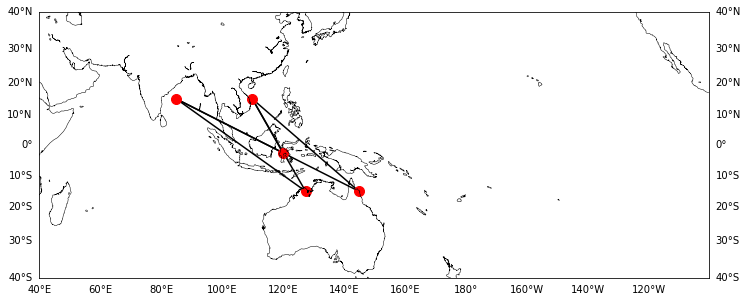

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.83it/s]


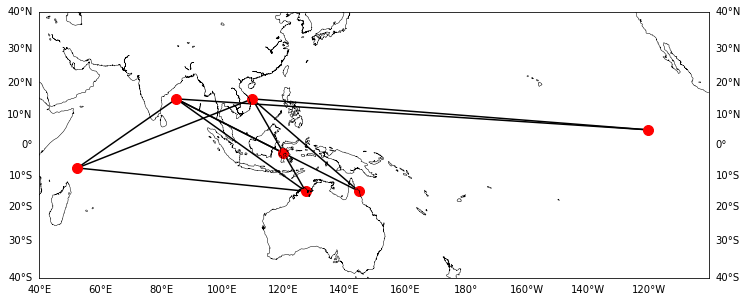

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.38it/s]


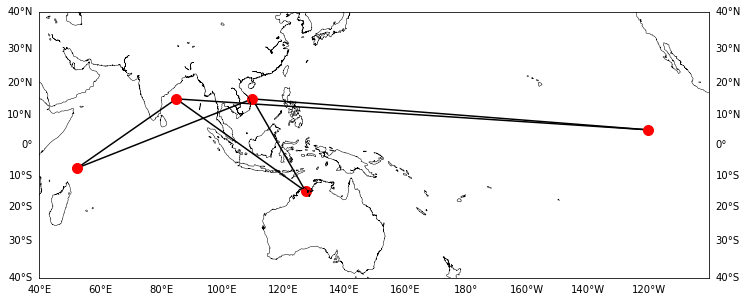

Mutual Information Noise level: 0.7
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.67it/s]


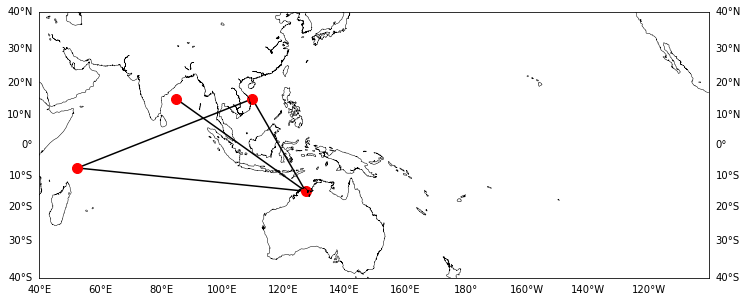

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.91it/s]


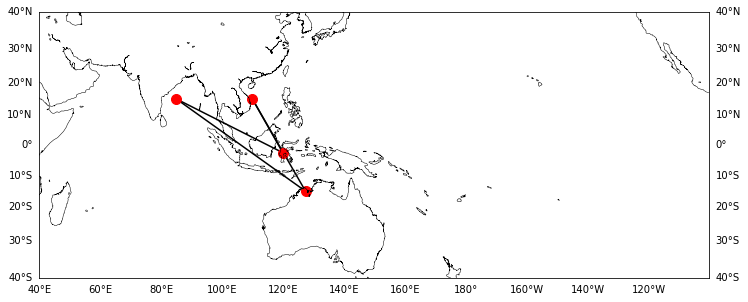

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.45it/s]


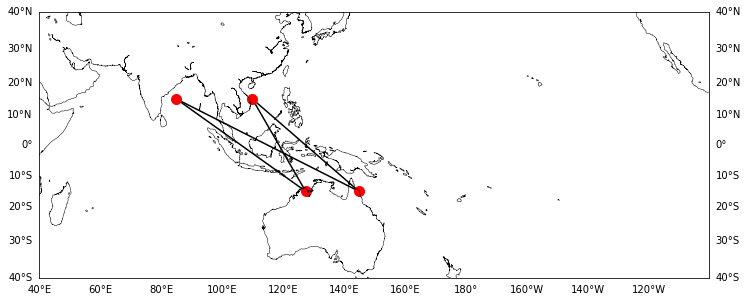

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.14it/s]


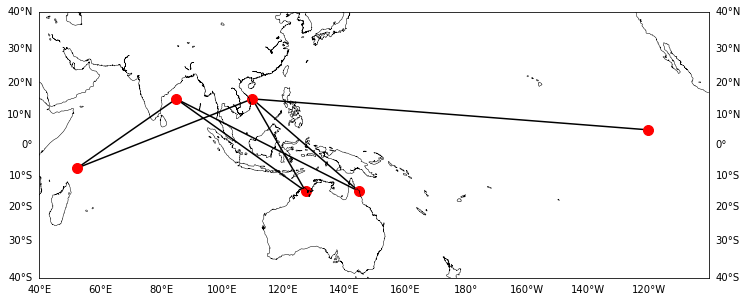

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.02it/s]


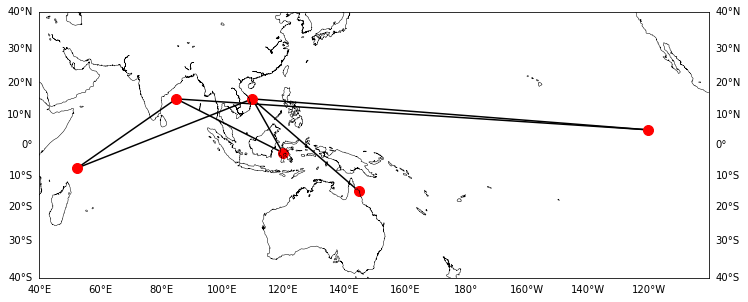

Mutual Information Noise level: 1.0
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.10it/s]


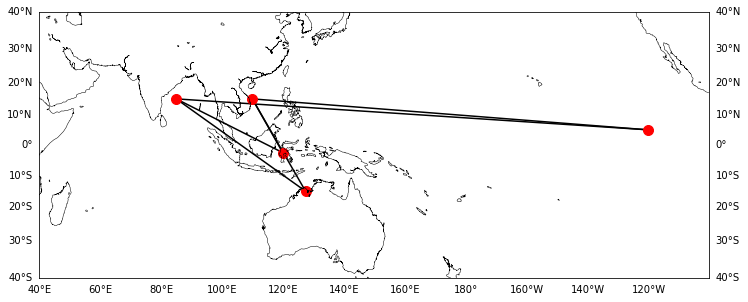

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.61it/s]


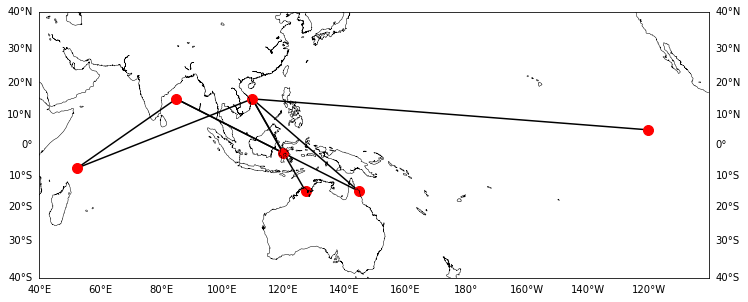

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.33it/s]


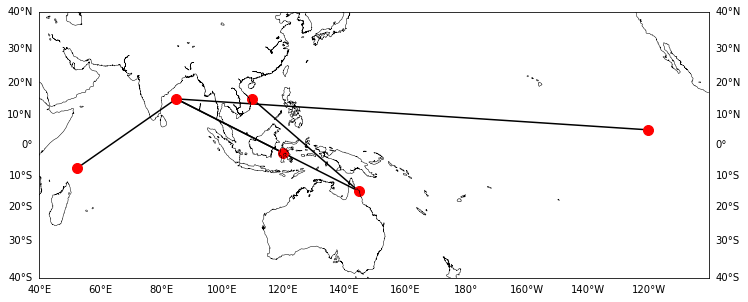

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.59it/s]


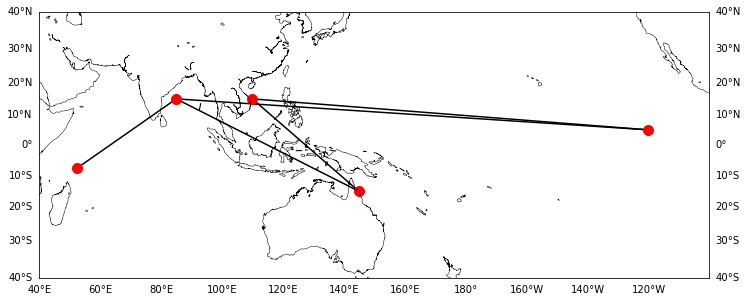

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.94it/s]


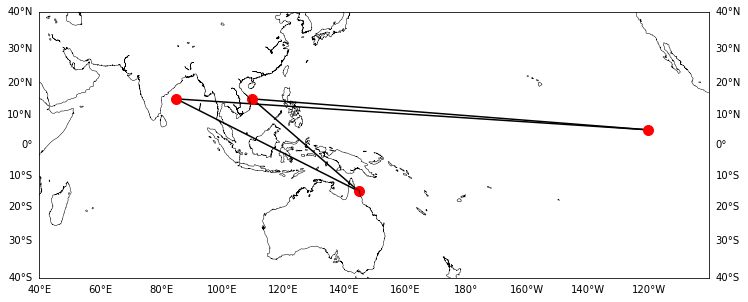

Mutual Information Noise level: 2.0
Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.53it/s]


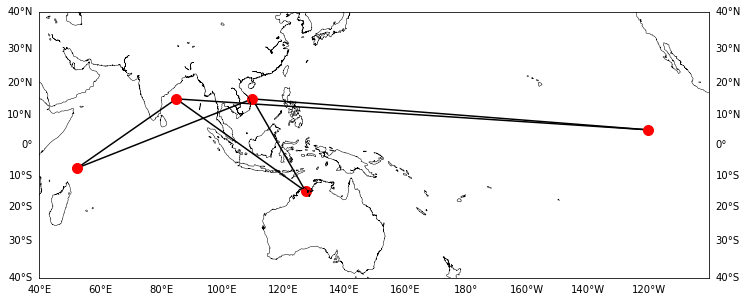

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.95it/s]


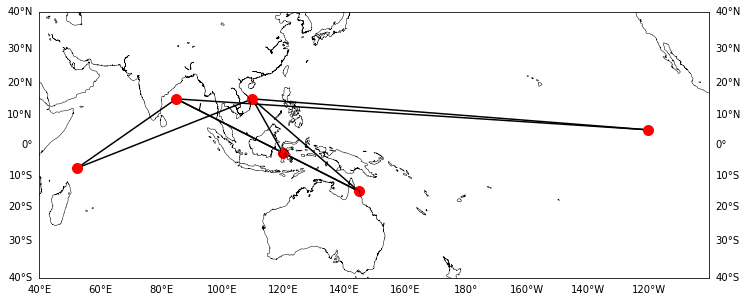

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.32it/s]


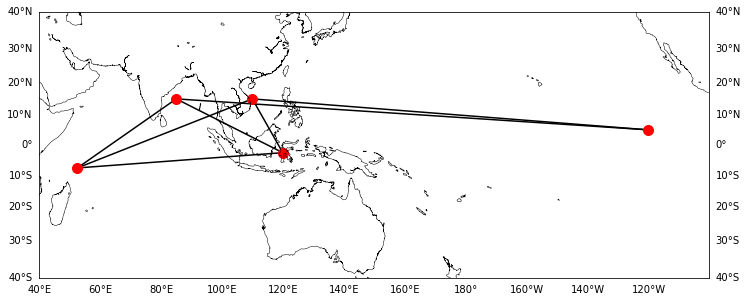

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.58it/s]


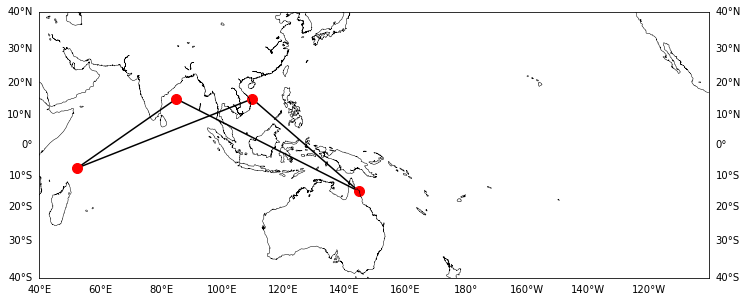

Using "white_noise_surrogates" algorithm.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.93it/s]


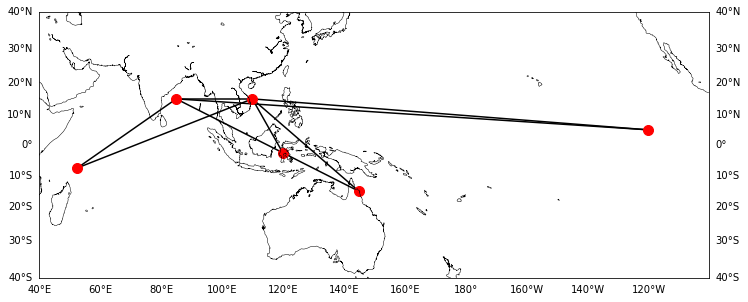

In [25]:
snrs = [0.4,0.5,0.6,0.7,1.0,2.0]
for i in range(len(snrs)):
    snr = snrs[i]
    print(f'Mutual Information Noise level: {snr}')
    for j in range(5):
        example_noise_0 = add_noise(five_monthly_0,snr)
        actual_noisy_mi = actual_mi(example_noise_0,20)
        test_noisy_mi = chopped_surrogate_testing_mi(example_noise_0,1000,12,20)
        
        test_mi_results = return_statistical_significance_mi(actual_noisy_mi,
                                                             test_noisy_mi,
                                                             99)
        #for j in range(len(test_mi_results)):
        #    print(test_mi_results[j])
        network_map_plot(test_mi_results)